In [1]:
import os
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import dill
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt
import wandb
from nnfabrik.builder import get_data
from nnfabrik.builder import get_data
from lurz2020.datasets.mouse_loaders import static_loaders
from lurz2020.models.models import se2d_fullgaussian2d
from lurz2020.training.trainers import standard_trainer as trainer
from lurz2020.utility.measures import get_correlations, get_fraction_oracles

import csng
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import RunningStats, crop, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters, plot_losses
from csng.losses import SSIMLoss, MSELossWithCrop, Loss
from csng.data import MixedBatchLoader
from csng.readins import (
    MultiReadIn,
    HypernetReadIn,
    ConvReadIn,
    AttentionReadIn,
    FCReadIn,
    AutoEncoderReadIn,
    Conv1dReadIn,
    LocalizedFCReadIn,
)

from encoder import get_encoder
from data_utils import (
    get_mouse_v1_data,
    append_syn_dataloaders,
    append_data_aug_dataloaders,
    RespGaussianNoise,
)

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

DATA_PATH='/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22'


In [2]:
config = {
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
    "crop_win": (22, 36),
}
print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Encoder

In [ ]:
encoder = get_encoder(device=config["device"], eval_mode=True)

In [ ]:
### load encoder
print("Loading encoder...")

### load pretrained encoder ckpt
encoder_ckpt = torch.load(
    os.path.join(DATA_PATH, "models", "encoder.pt"),
    map_location=config["device"],
)

### get temporary dataloaders for the encoder
_dataloaders = get_data(
    encoder_ckpt["config"]["data"]["dataset_fn"],
    encoder_ckpt["config"]["data"]["dataset_config"]
)

### init encoder
encoder = se2d_fullgaussian2d(
    **encoder_ckpt["config"]["encoder"]["model_config"],
    dataloaders=_dataloaders,
    seed=encoder_ckpt["config"]["seed"],
).float()
encoder.load_state_dict(encoder_ckpt["encoder_state"], strict=True)
encoder.to(config["device"])
encoder.eval()

In [ ]:
### validate encoder is working (corr on val set should be ~ 0.32)
train_correlation = get_correlations(encoder, _dataloaders["train"], device=config["device"], as_dict=False, per_neuron=False)
validation_correlation = get_correlations(encoder, _dataloaders["validation"], device=config["device"], as_dict=False, per_neuron=False)
test_correlation = get_correlations(encoder, _dataloaders["test"], device=config["device"], as_dict=False, per_neuron=False)

print(
    f"Correlation (train set):      {train_correlation:.3f}"
    f"\nCorrelation (validation set): {validation_correlation:.3f}"
    f"\nCorrelation (test set):       {test_correlation:.3f}"
)

## Data

In [4]:
dataloaders = dict()

### Mouse V1 dataset (Sensorium 2022)

In [ ]:
### prep data config
filenames = [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
    # "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # mouse 1
    # "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # sensorium+ (mouse 2)
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 3)
    # "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 4)
    # "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 5)
    # "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 6)
    # "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 7)
]
for f_idx, f_name in enumerate(filenames):
    filenames[f_idx] = os.path.join(DATA_PATH, f_name)

config["data"].update({
    "paths": filenames,
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": filenames,
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        "batch_size": 128,
        "seed": config["seed"],
        "use_cache": False,
    },
    "normalize_neuron_coords": True,
})

In [ ]:
## get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config)

In [ ]:
### show data
sample_data_key = dataloaders["mouse_v1"]["val"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["val"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.imshow(stim[0].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(122)
reshape_to = None
for i in range(30, 150):
    if resp.shape[-1] % i == 0:
        reshape_to = (i, resp.shape[-1] // i)
        break
if reshape_to != None:
    ax.imshow(resp[0].view(reshape_to).squeeze(0).unsqueeze(-1).cpu(), cmap="gray")

plt.show()

## Create synthetic data (1)
- Using the same stimuli as in Sens22 dataset

In [ ]:
data_part = "test"
assert len(dataloaders["mouse_v1"][data_part].data_keys) == 1,\
    "Create synthetic datasets one by one."
data_key = dataloaders["mouse_v1"][data_part].data_keys[0]
save_stats = False

print(f"{data_part=}  {data_key=}  {save_stats=}")

trans_to_apply = [
    {
        "name": "original",
        "stim": lambda x: x,
        "resp": lambda x: x,
        "save_dir": os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_key, data_part),
        "sample_idx": 0,
        "stats": RunningStats(num_components=encoder.readout[data_key].outdims, lib="torch", device=config["device"]),
    },
    # { ### noise to resp
    #     "name": "01noise_resp
    #     "stim": lambda x: x,
    #     "resp": lambda x: x + torch.randn(x.shape) * 0.1,
    #     "save_dir": os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_part + "_01noise_resp"),
    #     "sample_idx": 0,
    #     "stats": RunningStats(num_components=10000, lib="torch", device=config["device"]),
    # },
    # { ### flip stim
    #     "name": "flip_stim",
    #     "stim": lambda x: x.flip(2),
    #     "resp": lambda x: x,
    #     "save_dir": os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_part + "_flip_stim"),
    #     "sample_idx": 0,
    #     "stats": RunningStats(num_components=10000, lib="torch", device=config["device"]),
    # },
    # { ### rotate stim
    #     "name": "01rotate_stim",
    #     "stim": lambda x: torch.rot90(x, 1, (1, 2)),
    #     "resp": lambda x: x,
    #     "save_dir": os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_part + "_01rotate_stim"),
    #     "sample_idx": 0,
    #     "stats": RunningStats(num_components=10000, lib="torch", device=config["device"]),
    # },
    # { ### rotate stim
    #     "name": "02rotate_stim",
    #     "stim": lambda x: torch.rot90(x, 2, (1, 2)),
    #     "resp": lambda x: x,
    #     "save_dir": os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_part + "_02rotate_stim"),
    #     "sample_idx": 0,
    #     "stats": RunningStats(num_components=10000, lib="torch", device=config["device"]),
    # },
    # { ### rotate stim
    #     "name": "03rotate_stim",
    #     "stim": lambda x: torch.rot90(x, 3, (1, 2)),
    #     "resp": lambda x: x,
    #     "save_dir": os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_part + "_03rotate_stim"),
    #     "sample_idx": 0,
    #     "stats": RunningStats(num_components=10000, lib="torch", device=config["device"]),
    # },
]

### create dirs
for tran_to_apply in trans_to_apply:
    if os.path.exists(tran_to_apply["save_dir"]) and len(os.listdir(tran_to_apply["save_dir"])) > 0:
        print(f"[WARNING]: {tran_to_apply['save_dir']} already exists and is not empty.")
    os.makedirs(tran_to_apply["save_dir"], exist_ok=True)

In [ ]:
n_batches = len(dataloaders["mouse_v1"][data_part])

with torch.no_grad():
    ### run
    for batch_idx, b in enumerate(dataloaders["mouse_v1"][data_part]):
        for _data_key, (stim, _, neuron_coords, pupil_center) in b.items():
            assert _data_key == data_key, f"Data key mismatch: {data_key} vs. {_data_key}"
            for tran_to_apply in trans_to_apply:
                stim = tran_to_apply["stim"](stim.to(config["device"]))

                ### forward
                resp = encoder(stim, data_key=data_key)
                resp = tran_to_apply["resp"](resp)
                if save_stats:
                    tran_to_apply["stats"].update(resp)

                ### save
                for i in range(stim.shape[0]):
                    sample_path = os.path.join(tran_to_apply["save_dir"], f"{tran_to_apply['sample_idx']}.pickle")
                    with open(sample_path, "wb") as f:
                        pickle.dump({
                            "stim": stim[i].cpu(),
                            "resp": resp[i].cpu(),
                            "pupil_center": pupil_center[i].cpu(),
                        }, f)
                    tran_to_apply["sample_idx"] += 1

        ### log
        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx}/{n_batches}")

## save stats of responses
if save_stats:
    for tran_to_apply in trans_to_apply:
        np.save(
            os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_key, f"responses_mean_{tran_to_apply['name']}.npy"),
            tran_to_apply["stats"].get_mean().cpu().numpy(),
        )
        np.save(
            os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_key, f"responses_std_{tran_to_apply['name']}.npy"),
            tran_to_apply["stats"].get_std().cpu().numpy(),
        )

## save neuron_coords
p = os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_key, f"neuron_coords.npy")
np.save(p, neuron_coords.cpu().numpy())

In [ ]:
### load
# resp_mean = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", target_data_key, f"responses_mean_original.npy"))).float()
resp_std = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_key, f"responses_std_original.npy"))).float()

div_by = resp_std.clone()
thres = 0.01 * resp_std.mean()
idx = resp_std <= thres
div_by[idx] = thres

dataset = PerSampleStoredDataset(
    dataset_dir=os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", data_key, data_part),
    stim_transform=lambda x: x, # stim is already normalized
    resp_transform=csng.utils.Normalize(
        # mean=resp_mean,
        mean=0,
        std=div_by,
    ),
)

In [ ]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [ ]:
stats = RunningStats(num_components=resp.shape[-1], lib="torch", device="cpu")
for b, (s, r, pc) in enumerate(dataloader):
    # stats.update(s.view(s.shape[0], -1))
    stats.update(r)
    if b % 50 == 0:
        print(f"Batch {b} processed")

In [ ]:
stats.get_mean(), stats.get_std()

#### Fix wrongly calculated statistics

In [ ]:
### append synthetic data
config["data"]["syn_dataset_config"] = {
    "data_keys": [
        "21067-10-18",
        # "22846-10-16",
        # "23343-5-17",
        # "23656-14-22",
        # "23964-4-22",
    ],
    "batch_size": 32,
    "append_data_parts": ["train"],
    # "data_key_prefix": "syn",
    "data_key_prefix": None, # the same data key as the original (real) data
}

dataloaders = append_syn_dataloaders(dataloaders, config=config["data"]["syn_dataset_config"])

In [ ]:
resps_all = []
for b in dataloaders["mouse_v1"]["train"].dataloaders[-1]:
    resps_all.append(b.responses.cuda())
    print(len(resps_all))
resps_all = torch.cat(resps_all, dim=0)

In [ ]:
resps_all.mean(0), resps_all.std(0)

In [ ]:
np.save(
    os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", config["data"]["syn_dataset_config"]["data_keys"][0], f"responses_mean_original.npy"),
    resps_all.mean(0).cpu().numpy(),
)
np.save(
    os.path.join(DATA_PATH, "synthetic_data_mouse_v1_encoder", config["data"]["syn_dataset_config"]["data_keys"][0], f"responses_std_original.npy"),
    resps_all.std(0).cpu().numpy(),
)

## Create synthetic data (2)
- Using new stimuli (crops from ImageNet)
- Get stimuli from Sens22 data, crop 256x144 into different patches, and use as input to the encoder

#### Get base dataloader

In [5]:
### prep data config
filenames = [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
    # "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # mouse 1
    # "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # sensorium+ (mouse 2)
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 3)
    # "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 4)
    # "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 5)
    # "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 6)
    # "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 7)
]
for f_idx, f_name in enumerate(filenames):
    filenames[f_idx] = os.path.join(DATA_PATH, f_name)

config["data"]["mouse_v1"] = {
    "paths": filenames,
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": filenames,
        "normalize": True,
        "scale": 1.0, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        "batch_size": 1,
        "seed": config["seed"],
        "use_cache": False,
    },
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 1,
    "device": config["device"],
}

In [6]:
### get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config["data"])

In [ ]:
### show data
sample_data_key = dataloaders["mouse_v1"]["train"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["train"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[sample_data_key]
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_y_bins):
    for j in range(n_x_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[j] <= coords[:,0]) &\
               (coords[:,0] < x_bins[j + 1]) &\
               (y_bins[i] <= coords[:,1]) &\
               (coords[:,1] < y_bins[i + 1])
        binned_resp[i,j] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

#### Create synthetic data

In [ ]:
class SyntheticDataset(Dataset):
    """ Extracts patches from the given images and encodes them with a pretrained encoder ("on the fly"). """
    def __init__(
        self,
        base_dl,
        data_key,
        patch_shape,
        overlap=(0, 0),
        stim_transform=None,
        resp_transform=None,
        device="cpu",
    ):
        assert base_dl.batch_size == 1, "Batch size must be 1."
        assert len(overlap) == 2, "Overlap must be a tuple of 2 elements."
        self.base_dl = base_dl
        self.base_dl_iter = iter(base_dl)
        self.data_key = data_key
        self.patch_shape = patch_shape
        self.overlap = overlap
        self.stim_transform = stim_transform
        self.resp_transform = resp_transform
        self.device = device

        self.encoder = self._load_encoder()

        self.seen_idxs = set()

    def _load_encoder(self):
        """ Load pretrained encoder (predefined config) and return it. """
        print("Loading encoder...")
        encoder = get_encoder(device=self.device, eval_mode=True)
        return encoder.eval()

    def __len__(self):
        return len(self.base_dl)

    def __getitem__(self, idx):
        if idx in self.seen_idxs:
            raise ValueError(f"Index {idx} already seen.")
        self.seen_idxs.add(idx)

        sample = next(self.base_dl_iter)
        img, pupil_center = sample.images.to(self.device), sample.pupil_center.to(self.device)

        patches, syn_resps = self.extract_patches(img=img, pupil_center=pupil_center)
        return patches, syn_resps, pupil_center.repeat(patches.shape[0], 1)

    # def _scale_for_encoder(self, patches):
    #     ### scale to 0-100
    #     p_min, p_max = patches.min(), patches.max()
    #     return (patches - p_min) / (p_max - p_min) * 100

    @torch.no_grad()
    def extract_patches(self, img, pupil_center=None):
        h, w = img.shape[-2:]
        patches = []
        patch_shape = self.patch_shape

        for y in range(0, h - patch_shape[0] + 1, patch_shape[0] - self.overlap[0]):
            for x in range(0, w - patch_shape[1] + 1, patch_shape[1] - self.overlap[1]):
                # patch = img[:, y:y+patch_size, x:x+patch_size]
                patch = img[..., y:y+patch_shape[0], x:x+patch_shape[1]]
                patches.append(patch)

        # patches = torch.from_numpy(np.stack(patches)).float().to(self.device)
        # patches = torch.stack(patches).float().to(self.device)
        ### merge into a batch
        patches = torch.cat(patches, dim=0).to(self.device)

        ### encode patches = get resps
        # if self.expand_stim_for_encoder:
        #     patches_for_encoder = F.interpolate(patches, size=self.patch_size, mode="bilinear", align_corners=False)
        #     ### take only the center of the patch - the encoder's resps cover only the center part
        #     patches = patches[:, :, int(patch_size / 4):int(patch_size / 4) + self.patch_size,
        #                 int(patch_size / 4):int(patch_size / 4) + self.patch_size]
        # patches = self._scale_for_encoder(patches)
        if self.encoder is not None:
            if hasattr(self.encoder, "shifter") and self.encoder.shifter is not None:
                resps = self.encoder(patches, data_key=self.data_key, pupil_center=pupil_center.expand(patches.shape[0], -1))
            else:
                resps = self.encoder(patches, data_key=self.data_key)

        if self.resp_transform is not None:
            resps = self.resp_transform(resps)

        if self.stim_transform is not None:
            patches = self.stim_transform(patches)

        return patches, resps

In [ ]:
class BatchPatchesDataLoader():
    # dataloader that mixes patches from different images within a batch
    def __init__(self, dataloader):
        self.dataloader_iter = iter(dataloader)

    def __len__(self):
        return len(self.dataloader_iter)

    def __iter__(self):
        for batch in self.dataloader_iter:
            patches, resps, pupil_center = batch  # (B, N_patches, C, H, W)
            patches = patches.view(-1, *patches.shape[2:])
            resps = resps.view(-1, *resps.shape[2:])
            pupil_center = pupil_center.view(-1, *pupil_center.shape[2:])

            ### shuffle patch-resp pairs
            idx = torch.randperm(patches.shape[0])
            patches = patches[idx]
            resps = resps[idx].float()
            pupil_center = pupil_center[idx]

            yield patches, resps, pupil_center

In [ ]:
syn_data_config = {
    "data_part": "train",
    "patch_dataset": {
        "data_key": None, # to be set
        "patch_shape": (36, 64),
        "overlap": (0, 0),
        "stim_transform": None,
        "resp_transform": None,
        "device": config["device"],
    },
    "patch_dataloader": {
        "batch_size": 4,
        "shuffle": False,
    },
}
syn_data_config["patch_dataset"]["data_key"] = dataloaders["mouse_v1"][syn_data_config["data_part"]].data_keys[0]
print(f"data_part: {syn_data_config['data_part']}   data_key: {syn_data_config['patch_dataset']['data_key']}")

In [ ]:
base_dataloader = dataloaders["mouse_v1"][syn_data_config["data_part"]].dataloaders[0]

In [ ]:
patch_dataset = SyntheticDataset(base_dl=base_dataloader, **syn_data_config["patch_dataset"])
patch_dataloader = DataLoader(patch_dataset, **syn_data_config["patch_dataloader"])
dl = BatchPatchesDataLoader(dataloader=patch_dataloader)

In [ ]:
### test
s = patch_dataset[0]

fig = plt.figure(figsize=(10, 6))
axes = fig.subplots(4, 4).flatten()
for i in range(16):
    axes[i].imshow(s[0][i].squeeze().cpu(), cmap="gray")
plt.show()

In [ ]:
### test
for b in dl:
    break

fig = plt.figure(figsize=(20, 7))
axes = fig.subplots(4, 8).flatten()
for i in range(32):
    axes[i].imshow(b[0][i].squeeze().cpu(), cmap="gray")
    axes[i].axis("off")
plt.show()

#### Save synthetic data

In [ ]:
### config
data_part = "train"
save_dir = os.path.join(
    DATA_PATH,
    "synthetic_data_mouse_v1_encoder_new_stimuli",
    data_key,
    syn_data_config["data_part"],
)
os.makedirs(save_dir, exist_ok=True)
print(f"{save_dir=}")

### save config to parent folder
with open(os.path.join(os.path.dirname(save_dir), f"config_{syn_data_config['data_part']}.json"), "w") as f:
    json.dump(syn_data_config, f)

In [ ]:
### save
sample_idx = 0
for b_idx, (patches, resps, pupil_center) in enumerate(dl):
    for i in range(patches.shape[0]):
        sample_path = os.path.join(save_dir, f"{sample_idx}.pickle")
        with open(sample_path, "wb") as f:
            pickle.dump({
                "stim": patches[i].cpu(),
                "resp": resps[i].cpu(),
                "pupil_center": pupil_center[i].cpu(),
            }, f)
        sample_idx += 1

    if b_idx % 50 == 0:
        print(f"Batch {b_idx} processed")

#### Load synthetic data

In [7]:
### append synthetic data
config["data"]["syn_dataset_config"] = {
    "data_keys": [
        "21067-10-18",
        # "22846-10-16",
        # "23343-5-17",
        # "23656-14-22",
        # "23964-4-22",
    ],
    "batch_size": 32,
    "append_data_parts": ["train"],
    # "data_key_prefix": "syn",
    "data_key_prefix": None, # the same data key as the original (real) data
    "dir_name": "synthetic_data_mouse_v1_encoder_new_stimuli",
}

dataloaders = append_syn_dataloaders(dataloaders, config=config["data"]["syn_dataset_config"])

##### Compute stats

In [ ]:
max_samples, samples = 40000, 0
resps_all = []
for i, b in enumerate(dataloaders["mouse_v1"]["train"].dataloaders[-1]):
    resps_all.append(b.responses.cuda())
    samples += b.responses.shape[0]
    if samples >= max_samples:
        break
    if (i + 1) % 50 == 0:
        print(len(resps_all))

In [ ]:
resps_all = torch.cat(resps_all, dim=0).cpu()

In [ ]:
iqr = torch.quantile(resps_all, 0.75, dim=0) - torch.quantile(resps_all, 0.25, dim=0)
med = torch.median(resps_all, dim=0).values
mean = resps_all.mean(dim=0)
std = resps_all.std(dim=0)
iqr, med, mean, std

In [ ]:
if not os.path.exists(os.path.join(DATA_PATH, dataloaders["mouse_v1"]["train"].datasets[-1].dirname, "stats")):
    os.makedirs(os.path.join(DATA_PATH, dataloaders["mouse_v1"]["train"].datasets[-1].dirname, "stats"))
else:
    print("[WARNING] stats directory already exists")

In [ ]:
np.save(
    os.path.join(
        DATA_PATH,
        dataloaders["mouse_v1"]["train"].datasets[-1].dirname,
        "stats",
        f"responses_iqr.npy"
    ),
    iqr.cpu().numpy(),
)
np.save(
    os.path.join(
        DATA_PATH,
        dataloaders["mouse_v1"]["train"].datasets[-1].dirname,
        "stats",
        f"responses_mean.npy"
    ),
    mean.cpu().numpy(),
)
np.save(
    os.path.join(
        DATA_PATH,
        dataloaders["mouse_v1"]["train"].datasets[-1].dirname,
        "stats",
        f"responses_med.npy"
    ),
    med.cpu().numpy(),
)
np.save(
    os.path.join(
        DATA_PATH,
        dataloaders["mouse_v1"]["train"].datasets[-1].dirname,
        "stats",
        f"responses_std.npy"
    ),
    std.cpu().numpy(),
)

##### Inspect

Training dataset:	 76057 samples
Validation dataset:	 523 samples
Test dataset:		 100 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([32, 1, 36, 64])
  min=-1.750  max=2.198
  mean=-0.016  std=0.781
responses:
  torch.Size([32, 8372])
  min=-1.375  max=15.659
  mean=0.223  std=0.895
Neuron coordinates:
  torch.Size([8372, 3])
  min=-1.000  max=1.000
  mean=0.002  std=0.593
Pupil center:
  torch.Size([32, 2])
  min=-0.238  max=0.776
  mean=0.233  std=0.371


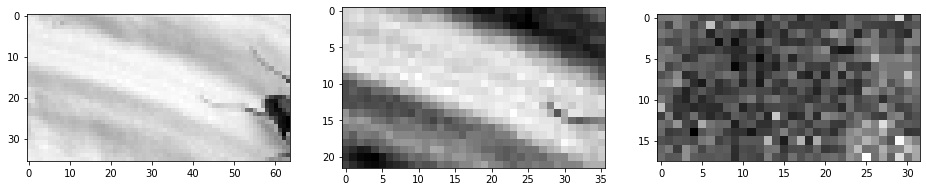

In [8]:
### show data
syn_stim, syn_resp, syn_pupil_center = next(iter(dataloaders["mouse_v1"]["train"].dataloaders[-1]))
syn_sample_data_key = dataloaders["mouse_v1"]["train"].data_keys[-1]
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * dl.batch_size for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {syn_stim.shape}"
    f"\n  min={syn_stim.min().item():.3f}  max={syn_stim.max().item():.3f}"
    f"\n  mean={syn_stim.mean().item():.3f}  std={syn_stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {syn_resp.shape}"
    f"\n  min={syn_resp.min().item():.3f}  max={syn_resp.max().item():.3f}"
    f"\n  mean={syn_resp.mean().item():.3f}  std={syn_resp.std().item():.3f}"
    "\nNeuron coordinates:"
    f"\n  {neuron_coords[syn_sample_data_key].shape}"
    f"\n  min={neuron_coords[syn_sample_data_key].min():.3f}  max={neuron_coords[syn_sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[syn_sample_data_key].mean():.3f}  std={neuron_coords[syn_sample_data_key].std():.3f}"
    "\nPupil center:"
    f"\n  {syn_pupil_center.shape}"
    f"\n  min={syn_pupil_center.min().item():.3f}  max={syn_pupil_center.max().item():.3f}"
    f"\n  mean={syn_pupil_center.mean().item():.3f}  std={syn_pupil_center.std().item():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(syn_stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(syn_stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[syn_sample_data_key]
H, W = syn_stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_x_bins):
    for j in range(n_y_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[i] <= coords[:,0]) &\
               (coords[:,0] < x_bins[i + 1]) &\
               (y_bins[j] <= coords[:,1]) &\
               (coords[:,1] < y_bins[j + 1])
        binned_resp[j,i] = syn_resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()